In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
data_dir = "../data/oct24_clean/"

games = pd.read_csv(data_dir + "games.csv")
genres = pd.read_csv(data_dir + "genres_translated.csv")
spy = pd.read_csv(data_dir + "steamspy_insights.csv") 
prom = pd.read_csv(data_dir + "promotional.csv")

In [4]:
# Define the folder containing the images
image_dir = "../data/img/header"

# Get list of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Extract numbers from filenames
app_ids = [int(os.path.splitext(f)[0]) for f in image_files]

# Create a DataFrame
df = pd.DataFrame({"app_id": app_ids})
df

,app_id
0,10
1,1000510
2,1001160
3,1002900
4,1006710
...,...
724,989060
725,9900
726,990080
727,992490


## Load Images

In [47]:
import cv2

def load_image(image_path):
    image = cv2.imread(image_path)  # Loads image in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

images = dict()

for app_id in df.app_id:
    images[app_id] = load_image(f"{image_dir}/{app_id}.jpg")

In [68]:
def show_images(imgs):
    fig, axes = plt.subplots(2, 2, figsize=(8, 4.5))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(imgs[i])
    plt.tight_layout()

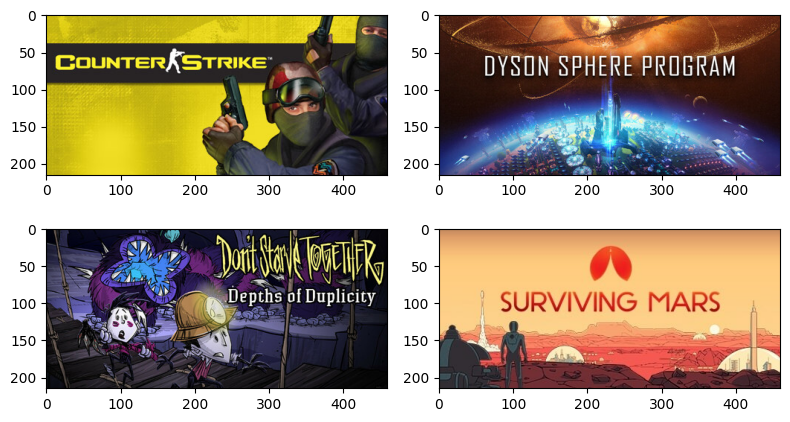

In [69]:
example_ids = [10, 1366540, 322330, 464920]
show_images([images[id] for id in example_ids])

## K-Means Quantization

In [70]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

def find_top_colors(image_array, k):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(image_array)
    return kmeans.cluster_centers_  # Get dominant colors

def replace_colors(image_array, top_colors):
    """Replace each pixel with the closest top color using KNN."""
    knn = NearestNeighbors(n_neighbors=1)  # Find the closest color
    knn.fit(top_colors)  # Train on the dominant colors
    _, indices = knn.kneighbors(image_array)  # Find closest colors
    
    # Map each pixel to its nearest top color
    replaced_image_array = top_colors[indices.flatten()]
    return replaced_image_array

### RGB

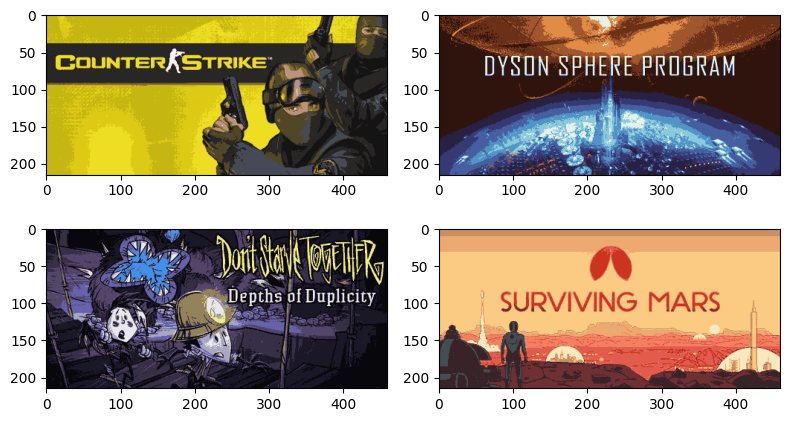

In [78]:
k = 10
knn_images = []

for img_idx in example_ids:
    flat_rgb = images[img_idx].reshape(-1, 3)

    top_colors = find_top_colors(flat_rgb, k)

    knn_image = replace_colors(flat_rgb, top_colors)
    knn_image = knn_image.reshape(images[img_idx].shape).astype(np.uint8)

    knn_images.append(knn_image)

show_images(knn_images)

### LAB

In [72]:
def rgb_to_lab(image_array):
    """Convert RGB image to LAB color space for better clustering."""
    image_array = image_array.reshape((1, -1, 3))  # Add extra dimension for OpenCV
    lab_image = cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_RGB2LAB)
    return lab_image

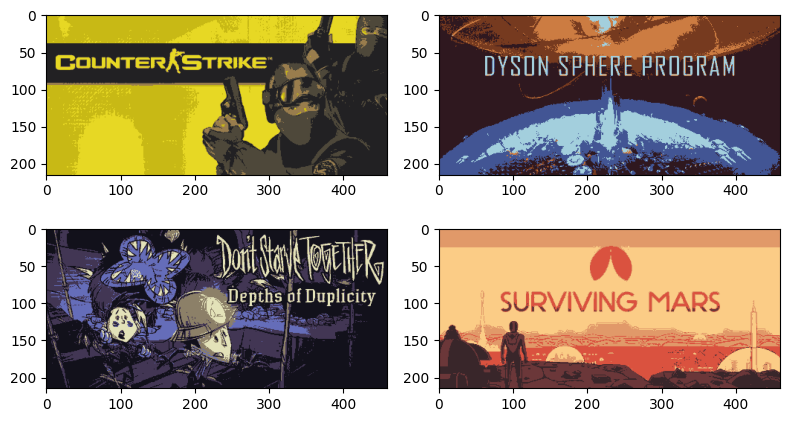

In [ ]:
k = 5
knn_images = []

for img_idx in example_ids:
    flat_lab = rgb_to_lab(images[img_idx]).reshape(-1, 3)

    top_colors = find_top_colors(flat_lab, k)

    knn_image = replace_colors(flat_lab, top_colors)
    knn_image = knn_image.reshape(images[img_idx].shape).astype(np.uint8)
    knn_image = cv2.cvtColor(knn_image, cv2.COLOR_LAB2RGB)

    knn_images.append(knn_image)

show_images(knn_images)

### Dominant Colors

In [89]:
qualitative_colors = {
    "Light Red": [230, 150, 150],
    "Dark Red": [150, 50, 50],
    "Light Green": [180, 230, 180],
    "Dark Green": [50, 120, 50],
    "Light Blue": [160, 190, 230],
    "Dark Blue": [50, 60, 150],
    "Teal": [100, 200, 200],
    "Turquoise": [140, 220, 220],
    "Light Yellow": [255, 240, 150],
    "Dark Yellow": [200, 180, 50],
    "Orange": [255, 180, 80],
    "Dark Orange": [200, 100, 50],
    "Light Purple": [200, 160, 220],
    "Dark Purple": [100, 50, 130],
    "Pink": [230, 170, 200],
    "Brown": [160, 120, 90],
    "Light Gray": [200, 200, 200],
    "Dark Gray": [120, 120, 120],
    "Black": [40, 40, 40],
    "White": [250, 250, 250]
}

qual_colors = np.array(list(qualitative_colors.values()))
qual_colors

array([[230, 150, 150],
       [150,  50,  50],
       [180, 230, 180],
       [ 50, 120,  50],
       [160, 190, 230],
       [ 50,  60, 150],
       [100, 200, 200],
       [140, 220, 220],
       [255, 240, 150],
       [200, 180,  50],
       [255, 180,  80],
       [200, 100,  50],
       [200, 160, 220],
       [100,  50, 130],
       [230, 170, 200],
       [160, 120,  90],
       [200, 200, 200],
       [120, 120, 120],
       [ 40,  40,  40],
       [250, 250, 250]])

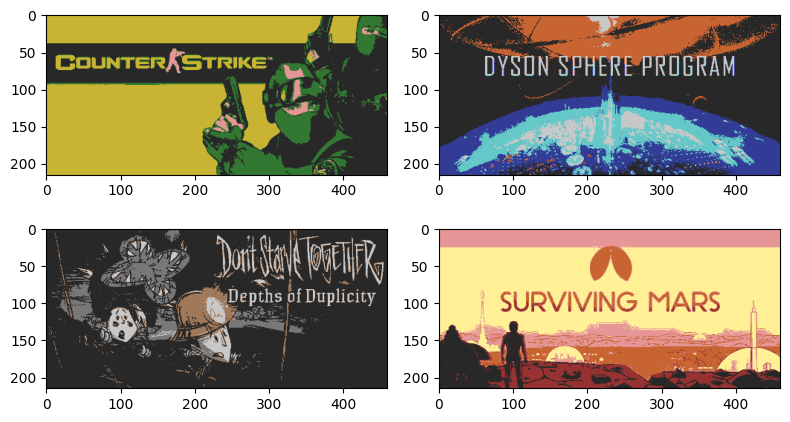

In [90]:
k = 5
knn_images = []

for img_idx in example_ids:
    flat_rgb = images[img_idx].reshape(-1, 3)

    top_colors = find_top_colors(flat_rgb, k)

    knn_image = replace_colors(flat_rgb, top_colors)
    knn_image = replace_colors(knn_image, qual_colors)
    knn_image = knn_image.reshape(images[img_idx].shape).astype(np.uint8)

    knn_images.append(knn_image)

show_images(knn_images)